In [85]:
#Importaciones
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
#conectar google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
#traer documento
filename = '/content/drive/My Drive/cust_seg.csv'
df = pd.read_csv(filename)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Customer Id      850 non-null    int64  
 2   Age              850 non-null    int64  
 3   Edu              850 non-null    int64  
 4   Years Employed   850 non-null    int64  
 5   Income           850 non-null    int64  
 6   Card Debt        850 non-null    float64
 7   Other Debt       850 non-null    float64
 8   Defaulted        700 non-null    float64
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 66.5 KB


In [88]:
#Limpieza y procesamiento
print('Duplicados:', df.duplicated().sum())
print('Faltan:', df.isna().sum().sum())

Duplicados: 0
Faltan: 150


###PROCEDO A ELIMINAR UNNAMED, COLUMNA SIN NOMBRE Y EL ID DEL USUARIO, NO SON IMPORTANTES PARA EL ACTIVIDAD.

In [89]:
df.drop(columns = ['Unnamed: 0', 'Customer Id'], inplace = True)


In [90]:
# Verificar que fue dado de baja
df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,41,2,6,19,0.124,1.073,0.0,6.3
1,47,1,26,100,4.582,8.218,0.0,12.8
2,33,2,10,57,6.111,5.802,1.0,20.9
3,29,2,4,19,0.681,0.516,0.0,6.3
4,47,1,31,253,9.308,8.908,0.0,7.2


In [91]:
# Mirar donde faltan los datos
print(df.isna().sum())
print()


Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64



In [92]:
#Rellenar de manera personal con el que más se repite o frecuente.
df['Defaulted'].fillna(0, inplace = True)

# Verificación
df.isna().sum()

Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
DebtIncomeRatio    0
dtype: int64

In [93]:
#mirar cuantos hay
df['Defaulted'].value_counts()

0.0    667
1.0    183
Name: Defaulted, dtype: int64

In [94]:
#Hcaer la estandarización de los datos
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

KMEANS

In [95]:
# Utilicen k-medias para crear diversos segmentos de los clientes.
inertias = []
silhouette_scores = []
for k in range(2, 10):
  kmeans = KMeans(n_clusters = k)
  kmeans.fit(scaled_df)
  inertias.append(kmeans.inertia_)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

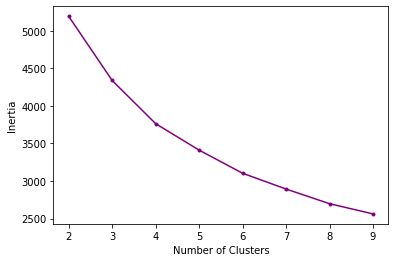

In [96]:
# GRAFICAR LAS INERCIAS
plt.plot(range(2, 10), inertias, color='purple', marker = '.');
plt.xlabel('Number of Clusters');
plt.ylabel('Inertia');

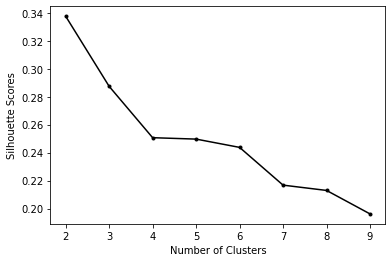

In [97]:
# Graficar las siluetas
plt.plot(range(2, 10), silhouette_scores, color='black', marker = '.');
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Scores');

UNA NOS DICE QUE DEBO USAR DOS Y LA OTRA QUE TRES, VAMOS A VER QUIÉN TIENE LA RAZÓN

Elegí el presunto caso en un interés en los años de empleo, las deudas y la edad del usuario.

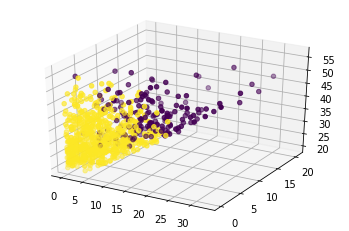

In [98]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(scaled_df)
df['clusters'] = kmeans.labels_
ax = plt.figure().add_subplot(projection = '3d')
ax.scatter(df['Years Employed'], df['Card Debt'], df['Age'], c = df['clusters'])

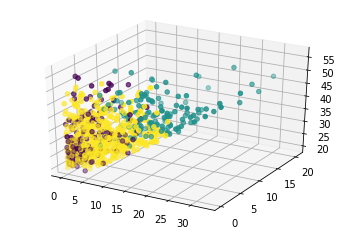

In [99]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scaled_df)
df['clusters'] = kmeans.labels_
ax = plt.figure().add_subplot(projection = '3d')
ax.scatter(df['Years Employed'], df['Card Debt'], df['Age'], c = df['clusters'])

###Aunque la silueta nos indica que deben ser dos, me parece que tres es más apegado a lo que nos dicen ambas gráficas de silueta e inercia.

In [100]:
#Haz gráficos de barras de los valores medios de cada característica para cada clúster que creaste en la parte 1 de esta asignación.  Cada trazo del eje X debe tener los clústeres, y el eje y debe tener valores medios para cada característica.

# Copiar el dataframe para nuevo objetivo.
final_df = df.copy()
final_model = KMeans(n_clusters = 3, random_state = 42)
final_model.fit(scaled_df)
final_df['clusters'] = final_model.labels_

# Agrupar los clusters
cluster_groups = final_df.groupby('clusters', as_index = False).mean()
cluster_groups

,clusters,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,43.000000,1.931973,17.197279,101.959184,4.220673,7.954483,0.129252,13.915646
1,1,31.891566,1.861446,3.963855,31.789157,1.576675,2.843355,0.987952,13.994578
2,2,33.817505,1.603352,7.625698,36.143389,0.853128,1.816855,0.000000,7.964991


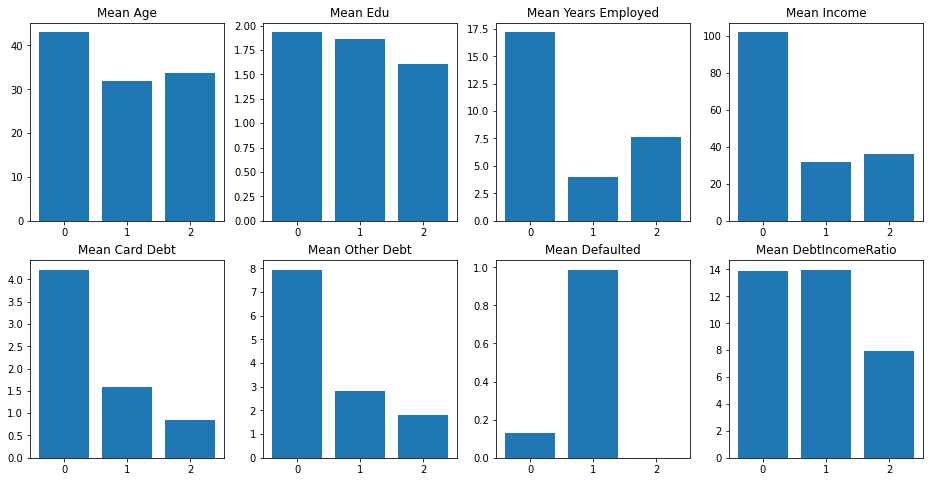

In [105]:
# Haz gráficos de barras de los valores medios de cada característica para cada clúster que creaste en la parte 1 de esta asignación.
fig, axes = plt.subplots(2, 4, figsize = (16, 8));
axes = axes.ravel();
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['clusters'], cluster_groups[col]);
  axes[i].set_title(f'Mean {col}')

###cluster 0: Los miembros del cluster 0 tienen el mayor radio de dinero y de experiencia , sin embargo son los mas endedudados. Aunque son de mas edad y con mas deuda, pagan a tiempo y no se dejan devorar por los intereses de deuda o mora.

###cluster 1: Aunque son los mas jovenes, son los que menos tiempo llevan trabajando o inmersos en el mercado laboral. Es por esto que puede haber un desorden en los gastos y haya mayor indice de deudas o pago desordenado o impulsivo.

###cluster 2: Aunque el cluster 1 y 2 tienen similitudes, los de este cluster tienen menos eduación y un poco más de años de empleo. Sus tasas son mejoes al tener menos promedio de deuda es por eso que al tener mas control sobre esas deudas, no hay grandes deudas o mora.
